# Synthetic Sonic Curves Generation

* __Author__: Gabriel Senra
* __Date__: 10/02/2022


- [1. Introduction: Synthetic Sonic Curves Generation](#first-bullet)
    - [1.1. Background](#first1-bullet)
    - [1.2. Problem Statement](#first2-bullet)
    - [1.3. Data Description](#first3-bullet)
    - [1.4. Evaluation Metric](#first4-bullet)
    - [1.5. Feature Engineering](#first5-bullet)


- [2. Imports](#second-bullet)


- [3. Methods](#thrid-bullet)


- [4. Split DataSets](#fourth-bullet)


- [5. Data Cleaning](#sixth-bullet)


- [6. References](#nineth-bullet)
    

In [88]:
import cowsay
import random
from quote import quote

#author
#book
falaVaquinha = quote(search)[random]['quote']

cowsay.cow(falaVaquinha)

  _________________________________________________
 /                                                 \
| Good. Item seven. The had had and that that probl |
| em. Lady Cavendish, weren’t you working on this?’ |
|  Lady Cavendish stood up and gathered her thought |
| s. ‘Indeed. The uses of had had and that that hav |
| e to be strictly controlled; they can interrupt t |
| he imaginotransference quite dramatically, causin |
| g readers to go back over the sentence in confusi |
| on, something we try to avoid.’ ‘Go on.’ ‘It’s mo |
| stly an unlicensed-usage problem. At the last cou |
| nt David Copperfield alone had had had had sixty  |
| three times, all but ten unapproved. Pilgrim’s Pr |
| ogress may also be a problem due to its had had/t |
| hat that ratio.’ ‘So what’s the problem in Progre |
| ss?’ ‘That that had that that ten times but had h |
| ad had had only thrice. Increased had had usage h |
| ad had to be overlooked, but not if the number ex |
| ceeds that that that usage.’ 

<a class="anchor" id="first1-bullet"></a>

## 1.1. Background

Well logs are interpreted/processed to estimate the in-situ petrophysical and geomechanical properties, which is essential for subsurface characterization. Various types of logs exist, and each provides distinct information about subsurface properties. Certain well logs, like gamma ray (GR), resistivity, density, and neutron logs, are considered as “easy-to-acquire” conventional well logs that are run in most of the wells. Other well logs, like nuclear magnetic resonance, dielectric dispersion, elemental spectroscopy, and sometimes sonic logs, are only run in limited number of wells.

Sonic travel-time logs contain critical geomechanical information for subsurface characterization around the wellbore. Often, sonic logs are required to complete the well-seismic tie workflow or geomechanical properties prediction. When sonic logs are absent in a well or an interval, a common practice is to synthesize them based on its neighboring wells that have sonic logs. This is referred to as sonic log synthesis or pseudo sonic log generation.

<a class="anchor" id="first2-bullet"></a>

## 1.2. Problem Statement

Compressional travel-time (DT) logs are not acquired in all the wells drilled in a field due to financial or operational constraints. Under such circumstances, machine learning techniques can be used to predict DT logs to improve subsurface characterization. The goal of the study is to develop data-driven models by processing “easy-to-acquire” conventional logs from a list of weels, and use the data-driven models to generate synthetic compressional logs (DT) in rest of Wells. A robust data-driven model for the desired sonic-log synthesis will result in low prediction errors, which can be quantified in terms of Root Mean Squared Error by comparing the synthesized and the original DT logs.

You need to build a generalizable data-driven models using train dataset. Following that, you will deploy the newly developed data-driven models on test dataset to predict DT logs. The data-driven model should use feature sets derived from the following 6 logs: NPHI, GR, CALI, DEPT, RHOB, ILD. The data-driven model should synthesize the target logs: DT.

<a class="anchor" id="first3-bullet"></a>

## 1.3. Data Decription 

- Curve: DEPT, Units: M, Description: Measured Depth
- Curve: CALI, Units: in, Description: CALIPER
- Curve: DT, Units: us/ft, Description: DELTA-T (ALSO CALLED SLOWNESS OR INTERVAL TRANSIT TIME)
- Curve: GR, Units: gAPI, Description: GAMMA RAY
- Curve: RHOB, Units: g/cm3, Description: BULK DENSITY
- Curve: NPHI, Units: %, Description: THERMAL NEUTRON POROSITY (ORIGINAL RATIO METHOD) IN SELECTED LITHOLOGY
- Curve: ILD, Units: ohm.m, Description: INDUCTION DEEP RESISTIVITY

<a class="anchor" id="first4-bullet"></a>

## 1.4. Evaluation Metric

We will be evaluated by the metirc Root Mean Squared Error and r².

The RMSE is calculated as:

### RMSE = $\sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}$

Where:

- "di" is the predicted curve for DT
- "fi" is the true value for evaluation.

DT are in the same weight during the evaluation

Understanding and optimizing your predictions for this evaluation metric is paramount for this chalange.

<a class="anchor" id="first5-bullet"></a>

## $R^2 = \frac {{SS}_{regression}}{{SS}_{total}} = 1 - \frac{\sum_{i}({y}_{i} - \hat{y}_{i})^2}{\sum_{i}({y}_{i} - \bar{y}_{i})^2}$

## 1.5. Base Line

### Faust's Equation = $\frac{1000}{({2*DEPT*ILD})^{\frac{1}{6}}}$

<a class="anchor" id="second-bullet"></a>

## 1.6. Standard Scaler - Z-Score

## $ z =\frac{x_i-\mu}{\sigma} $

# 2. Imports

In [23]:
# import libraries
import pandas as pd
import numpy as np
import lasio
import os
import math
import shutil

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.express as px
import missingno as msno

# import sklearn libararies
from arcgis.gis import GIS
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

<a class="anchor" id="thrid-bullet"></a>

# 3. Methods

In [3]:
#Função recebe duas listas com minemônicos a modificar e seu padrão.
def standartazeColumns(atual, ideal):        
    global well
    for j in range (len(well.columns)):
        for s in range(len(atual)):
            if well.columns[j] == atual[s]:
                well = well.rename(columns={atual[s]: ideal[s]})
                #print(atual[s])
                #print("Poço Padronizado: ",las.well.WELL.value)

In [4]:
#Extrai a latitude o longitudo do arquivo, convrte e adiciona as viariaveis ao df
def getLatiLong(lati,long):
    global well
    if ":" in str(well['LATI'][0]):
        well[['degreeLati', 'minuteLati', 'seccondLati']] = pd.DataFrame([x.split(":") for x in well['LATI'].tolist()])
        well['LATI'] = (int(well['degreeLati'][0]))+(float(well['minuteLati'][0])/60)+(float(well['seccondLati'][0])/3600)

        well[['degreeLong', 'minuteLong', 'seccondLong']] = pd.DataFrame([x.split(":") for x in well['LONG'].tolist()])
        well['LONG'] = (int(well['degreeLong'][0]))+(float(well['minuteLong'][0])/60)+(float(well['seccondLong'][0])/3600)
        well = well.drop(columns = ['degreeLati','degreeLong','minuteLati','minuteLong','seccondLati','seccondLong'])

In [5]:
#Seleciona os poços que contem a lista de minemonicos de interesse
def selectMinemonico(listaDB, wellName, minemonicos, selectedTrainingList):
    for i in range (len(listaDB)):
        count = 0
        for j in range(len(minemonicos)):
            if (minemonicos[j] in listaDB[i].columns):
                count = count+1
        if count == len(minemonicos):
            selectedTrainingList.append(listaDB[i])
            selectedTrainingListName.append(wellName[i])
            #print(wellName[i])
            #print(listaDB[i].columns)

<a class="anchor" id="fourth-bullet"></a>

In [6]:
def result_plot(y_predict, y_real):
    # check the accuracy of predicted data and plot the result
    print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_real, y_predict))))
    plt.subplots(figsize=(42,12))
    plt.subplot(2, 2, 1)
    plt.plot(y_real[:])
    plt.plot(y_predict[:])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DT')
    plt.title('DT Prediction Comparison')
    
    plt.subplot(2, 2, 3)
    plt.scatter(y_real[:], y_predict[:])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DT Prediction Comparison')
    
    plt.show()

In [7]:
def grid_search(clf, param_grid, X_train, y_train):

    grid = GridSearchCV(estimator=clf,
                        param_grid=param_grid, 
                        scoring='r2', 
                        cv=5)
    grid.fit(X_train, y_train.ravel())
    print("R²:")
    print(grid.best_score_) #ROC AUC
    
    return grid.best_estimator_

In [8]:
def wellLogPlot():
    fig, ax = plt.subplots(figsize=(10,10))

    #Set up the plot axes
    ax1 = plt.subplot2grid((1,3), (0,0), rowspan=1, colspan = 1)
    ax2 = plt.subplot2grid((1,3), (0,1), rowspan=1, colspan = 1)
    ax3 = plt.subplot2grid((1,3), (0,2), rowspan=1, colspan = 1)
    ax4 = ax2.twiny() #Twins the y-axis for the density track with the neutron track
    ax5 = ax3.twiny() #Twins the y-axis for the density track with the neutron track

    # As our curve scales will be detached from the top of the track,
    # this code adds the top border back in without dealing with splines
    ax7 = ax1.twiny()
    ax7.xaxis.set_visible(False)
    ax8 = ax2.twiny()
    ax8.xaxis.set_visible(False)
    ax9 = ax3.twiny()
    ax9.xaxis.set_visible(False)

    # Gamma Ray track
    ax1.plot("GR", "DEPT", data = df[s], color = "green",linewidth=0.5)
    ax1.set_xlabel("Gamma")
    ax1.xaxis.label.set_color("green")
    ax1.set_ylabel("Depth (m)")
    ax1.tick_params(axis='x', colors="green")
    ax1.spines["top"].set_edgecolor("green")
    ax1.title.set_color('green')
    ax1.set_xticks([0, 50, 100, 150, 200])

    # Density track
    ax2.plot("RHOB", "DEPT", data = df[s], color = "red",linewidth=0.5)
    ax2.set_xlabel("Density")
    ax2.xaxis.label.set_color("red")
    ax2.tick_params(axis='x', colors="red")
    ax2.spines["top"].set_edgecolor("red")
    ax2.set_xticks([1.95, 2.2, 2.45, 2.7, 2.95])

    # Sonic track
    ax3.plot("DT", "DEPT", data = df[s], color = "purple",linewidth=0.5)
    ax3.set_xlabel("Sonic")
    ax3.xaxis.label.set_color("purple")
    ax3.tick_params(axis='x', colors="purple")
    ax3.spines["top"].set_edgecolor("purple")

    # Neutron track placed ontop of density track
    ax4.plot("NPHI", "DEPT", data = df[s], color = "blue",linewidth=0.5)
    ax4.set_xlabel('Neutron')
    ax4.xaxis.label.set_color("blue")
    ax4.tick_params(axis='x', colors="blue")
    ax4.spines["top"].set_position(("axes", 1.08))
    ax4.spines["top"].set_visible(True)
    ax4.spines["top"].set_edgecolor("blue")

    # Synthetic Sonic - Neural Net AI
    ax5.plot("SYNTHETIC SONIC", "DEPT", data = df[s], color = "orange",linewidth=1)
    ax5.set_xlabel("Synthetic Sonic")
    ax5.xaxis.label.set_color("orange")
    ax5.tick_params(axis='x', colors="orange")
    ax5.spines["top"].set_position(("axes", 1.08))
    ax5.spines["top"].set_visible(True)
    ax5.spines["top"].set_edgecolor("orange")

    # Synthetic Sonic - Faust's Equsion
    # ax5.plot("DT_F", "DEPT", data = df[s], color = "orange",linewidth=1)
    # ax5.set_xlabel("Synthetic Sonic")
    # ax5.xaxis.label.set_color("orange")
    # ax5.tick_params(axis='x', colors="orange")
    # ax5.spines["top"].set_position(("axes", 1.08))
    # ax5.spines["top"].set_visible(True)
    # ax5.spines["top"].set_edgecolor("orange")

    # Common functions for setting up the plot can be extracted into
    # a for loop. This saves repeating code.
    for ax in [ax1, ax2, ax3]:
        #ax.set_ylim(4850, 4600)
        ax.grid(which='major', color='lightgrey')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))


    plt.tight_layout()

# 4. Split Datasets

- 

In [9]:
%cd "C:\Users\James Bond\Desktop\AI\LP Updated"

#Todos os bancos de dados disponíveis
lasList = pd.DataFrame(os.listdir())[0].tolist()
lasListName = []
lasListWell = []

#Poços a serem utilizados como treino (Com DT)
training_list = []
training_listName = []

#Poços a serem preditos (Sem DT)
toPredict = []
toPredictName = []

#Poços com e sem Latitude e Longitude a serem tratados
semLatiLongName = []
semLatiLongWell = []

comLatiLongName = []
comLatiLongWell = []

#Defino os possiveis nomes a serem padronizados e o nome padronizado
atual = ["MSFL","RXOZ","MDT","RHOZ","CAL","HCAL","DEPTH"]
ideal = ["RXO","RXO","DT","RHOB","CALI","CALI","DEPT"]

#Seperar os dados a serem pré-processados
for i in range (len(lasList)):

    #Ler arquivo las e de seus minemônicos
    las = lasio.read(lasList[i])
    well = (las.df()).reset_index()

    #Padronizar
    standartazeColumns(atual, ideal)

    #Feature Engenieering
    well['LATI'] = las.well.LATI.value
    well['LONG'] = las.well.LONG.value

    getLatiLong(well['LATI'],well['LONG'])

    lasListName.append(las.well.WELL.value)
    lasListWell.append(well)

    if well['LATI'][0] == -19:
        semLatiLongName.append(las.well.WELL.value)
        semLatiLongWell.append(well)
    else:
        comLatiLongName.append(las.well.WELL.value)
        comLatiLongWell.append(well)

    #Separar os poços com e sem DT
    count = 0
    for j in range(len(well.columns)):
        if well.columns[j] == "DT":
            count += 1
            training_list.append(lasListWell[i])
            training_listName.append(las.well.WELL.value)

    if count == 0:
        toPredict.append(lasListWell[i])
        toPredictName.append(las.well.WELL.value)

print("There are", len(lasList), "well logs in Lagoa Parda, of which", len(training_list),"have registered DT, other", len(toPredict),"wells do not have DT.")

C:\Users\James Bond\Desktop\AI\LP Updated
There are 88 well logs in Lagoa Parda, of which 29 have registered DT, other 59 wells do not have DT.


<a class="anchor" id="fouth1-bullet"></a>

# 5. Build Machine Models

## 5.1. Data Cleaning

In [10]:
#Seleciona os poços que contem o minemonicos de interesse

minemonicos = ['NPHI', 'GR', 'CALI', 'DT', 'DEPT', 'RHOB', 'ILD']
selectedTrainingListWell = []
selectedTrainingListName = []

selectMinemonico(training_list, training_listName, minemonicos, selectedTrainingListWell)

In [11]:
#Tratamento dos valores faltantes e inconsistentes
for i in range(len(selectedTrainingListWell)):
    selectedTrainingListWell[i] = selectedTrainingListWell[i].dropna()
    selectedTrainingListWell[i] = selectedTrainingListWell[i][minemonicos]
    selectedTrainingListWell[i] = selectedTrainingListWell[i][(selectedTrainingListWell[i]['DT'] < 170)]

In [12]:
#Ao remover os nulos obtemos poços sem registro.Os poços que não podem ser avaliados foram removidos.
df = []

for i in range(len(selectedTrainingListWell)):
    if len(selectedTrainingListWell[i]) != 0:
        df.append(selectedTrainingListWell[i])

# 6. Prediction

## 6.1. Cross Validation - Random Forest

R²:
0.28681580386658495
Root Mean Square Error is: 13.07184


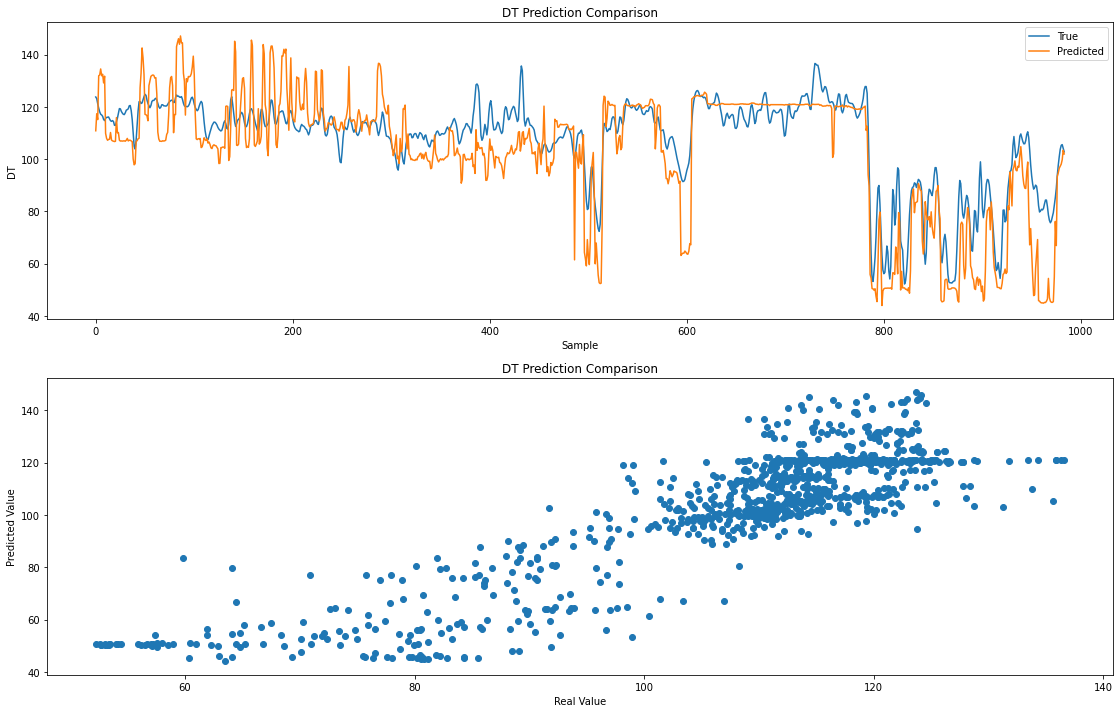

C:\Users\James Bond\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\James Bond\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\James Bond\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 304, in fit
    X, y = self._validate_data(X, y, multi_output=True,
  File "C:\Users\James Bond\anaconda3\lib\site-packages\sklearn\base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\James Bond\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\James Bond\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 814, in check_X_y
    X = check_array

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

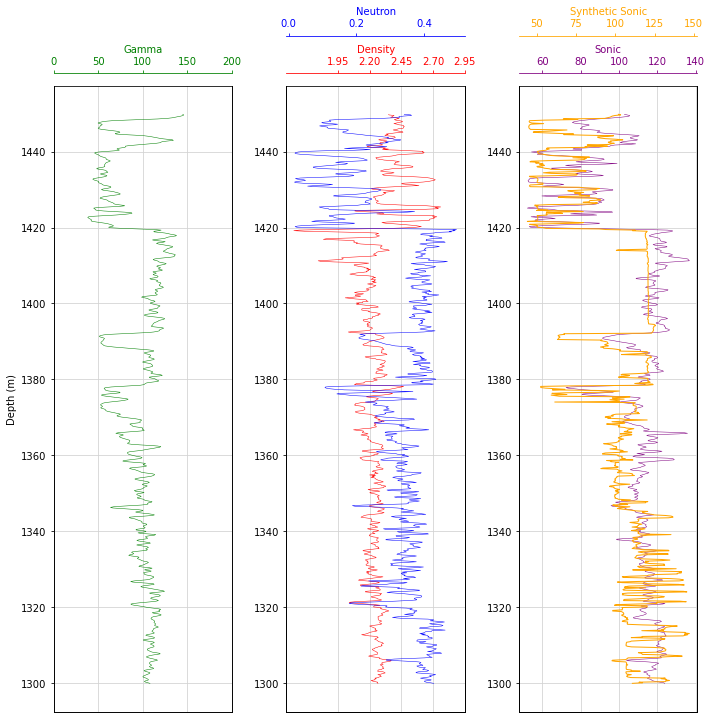

In [13]:
for s in range(len(df)):
    df2 = df[:s] + df[s+1:]

    trainingWell = []
    for i in range(len(df2)):
        trainingWell.append(df2[i])
    
    #VER LOGICA,FOR NAO COLETA BANCO DE INTERESSE    
    
    trainingWell = pd.concat(trainingWell).reset_index(drop = True)
    
    x_trainWell = trainingWell.loc[:, trainingWell.columns != 'DT'].values
    y_trainWell  = trainingWell.loc[:, trainingWell.columns == 'DT'].values

    
    # standize the matrix for training data
    scaler = StandardScaler()
    x_trainWell = scaler.fit_transform(x_trainWell)
    
    X_test = df[s].loc[:, df[s].columns != 'DT'].values
    y_test = df[s].loc[:, df[s].columns == 'DT'].values

    X_test = scaler.fit_transform(X_test)

    # run the prediction
    RF = RandomForestRegressor(n_estimators=100, random_state=100)
    RF_best = grid_search(RF, {}, x_trainWell, y_trainWell)
    well_predict = RF_best.predict(X_test)

    result_plot(well_predict,y_test)
    
    df[s]['SYNTHETIC SONIC'] = well_predict
    df[s]['DT_F'] = 1000/((2*df[s]['DEPT']*df[s]['ILD'])**(1/3.6))
    
    wellLogPlot()

<a class="anchor" id="seventh1-bullet"></a>

<a class="anchor" id="nineth-bullet"></a>

## 7. References:

https://github.com/pddasig/Machine-Learning-Competition-2020/blob/master/Synthetic%20Sonic%20Log%20Generation%20Starter_Yu%202_27_2020.ipynb
    
https://github.com/andymcdgeo/Petrophysics-Python-Series/blob/master/14%20-%20Displaying%20Lithology%20Data.ipynb
    
https://github.com/andymcdgeo/Petrophysics-Python-Series/blob/master/05%20-%20Petrophysical%20Calculations.ipynb
    
https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html
    
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

Competition%20Summay%20-%20Pseudo%20Sonic%20Log%20Generation.pdf